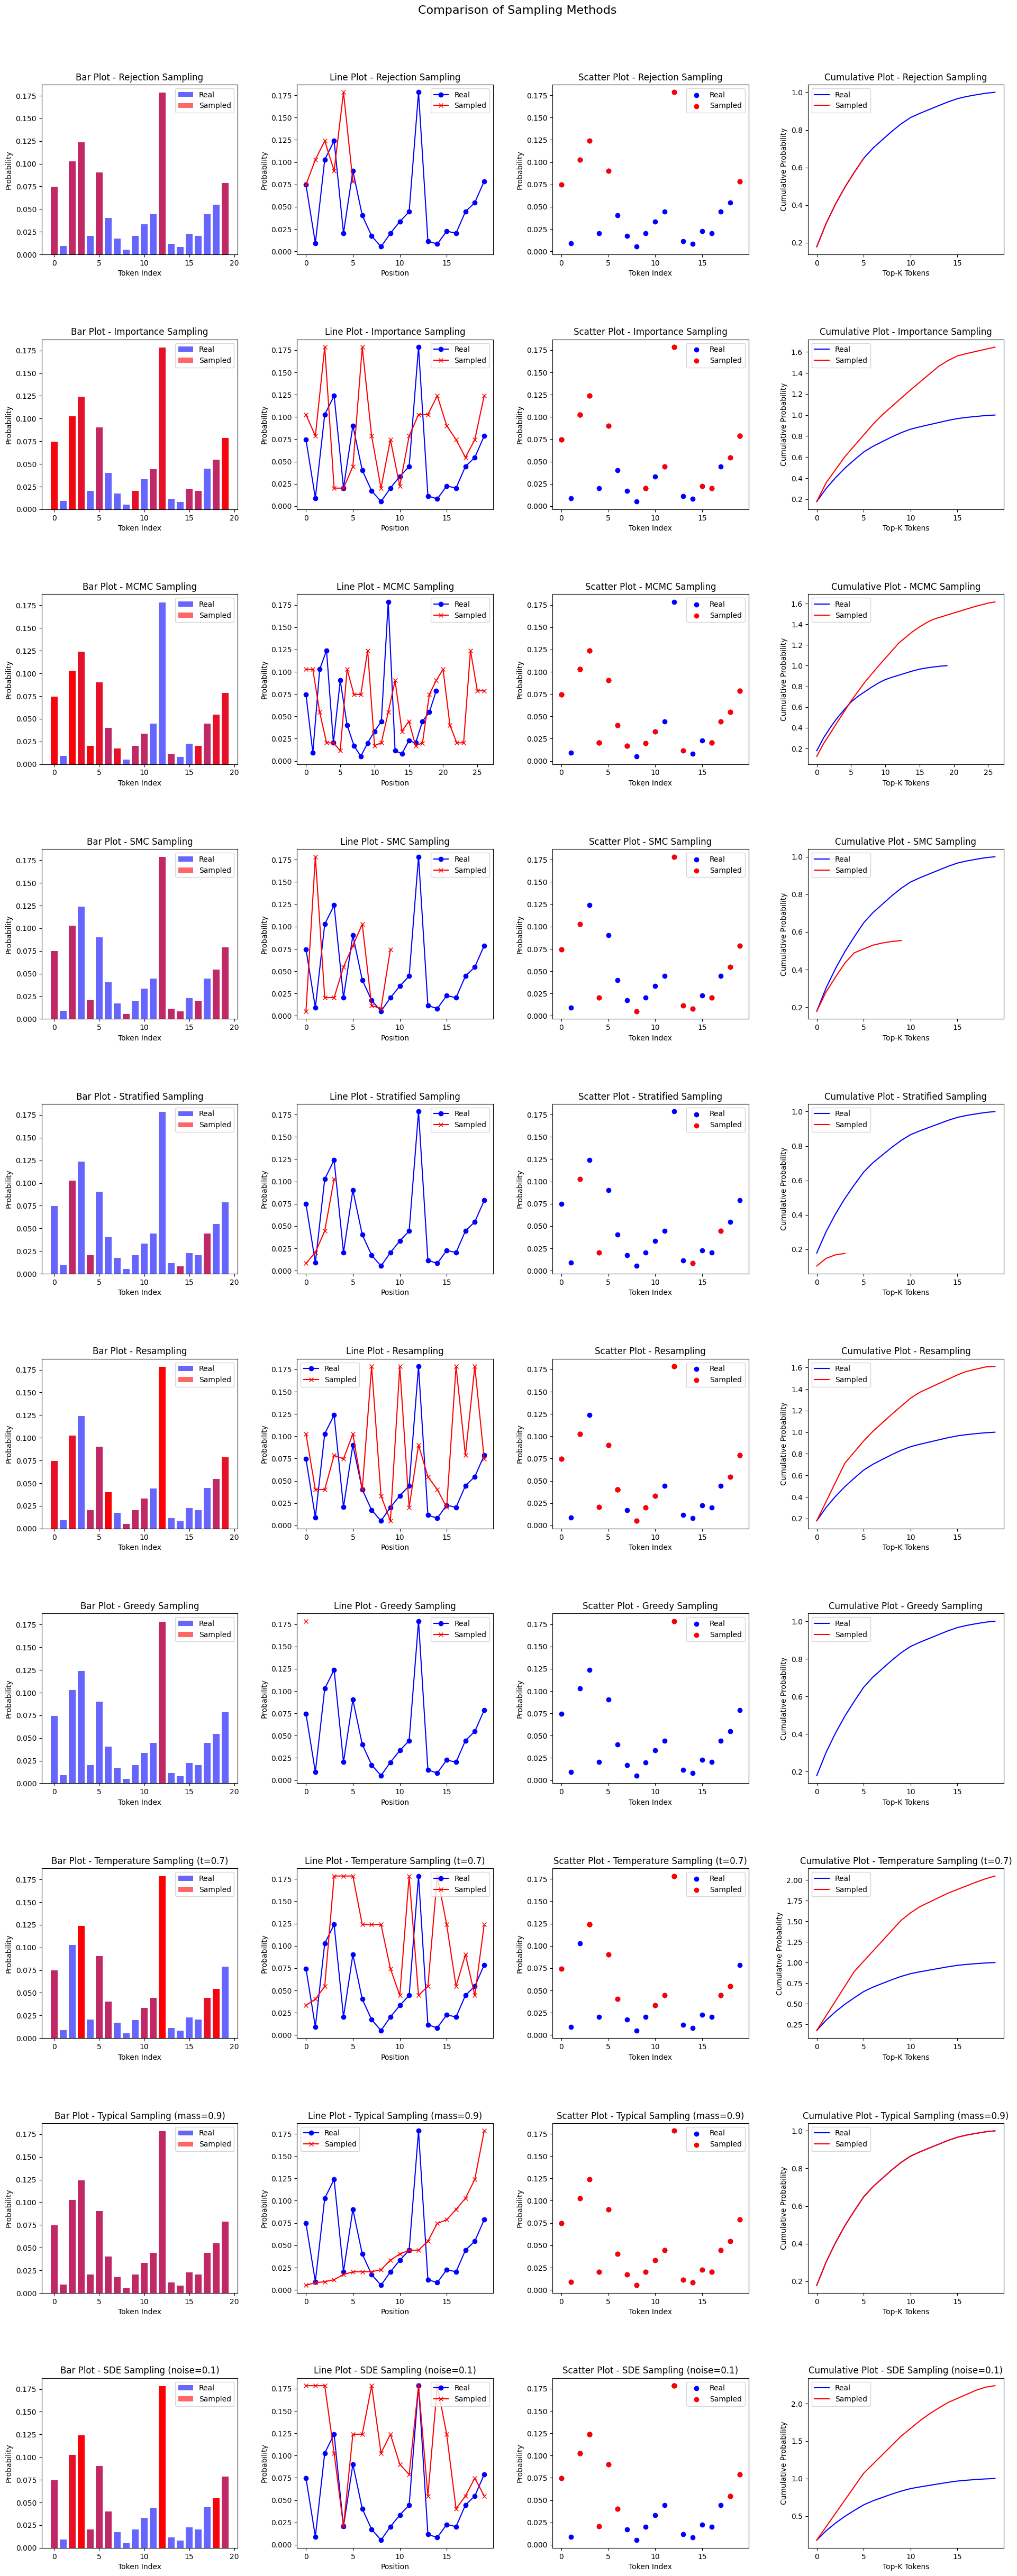


Sampling Method Metrics:
Method                    Mean Prob  Diversity  Top-1 %    Top-5 %   
--------------------------------------------------------------------------------
Rejection Sampling        0.1511    0.0000    0.5000    1.0000
Importance Sampling       0.0610    0.3000    0.0500    0.3500
MCMC Sampling             0.0968    0.6087    0.2609    0.6522
SMC Sampling              0.0666    0.0000    0.1000    0.4000
Stratified Sampling       0.0416    0.0000    0.0000    0.2500
Resampling                0.0939    0.5000    0.2000    0.6000
Greedy Sampling           0.1783    0.0000    1.0000    1.0000
Temperature Sampling      0.1164    0.6000    0.3500    0.7500
Typical Sampling          0.0500    0.0000    0.0500    0.2500
SDE Sampling              0.0928    0.5000    0.2000    0.5500


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Mock draft model's tokenization and probabilities
def draft_model_tokenizer():
    tokens = [f"token_{i}" for i in range(20)]
    probabilities = np.random.dirichlet(np.ones(len(tokens)))  # Real probability distribution
    return tokens, probabilities

# Original sampling methods
def rejection_sampling(tokens, probabilities):
    accepted = []
    threshold = random.uniform(0, max(probabilities))
    for i, p in enumerate(probabilities):
        if p > threshold:
            accepted.append(i)
    # Handle case where no tokens pass threshold
    if not accepted:
        accepted = [np.argmax(probabilities)]
    return accepted

def importance_sampling(tokens, probabilities):
    weights = probabilities / np.sum(probabilities)
    indices = random.choices(range(len(tokens)), weights=weights, k=len(tokens))
    return indices

def mcmc_sampling(tokens, probabilities, n_iter=50):
    current = random.randint(0, len(probabilities) - 1)
    accepted = [current]
    for _ in range(n_iter):
        candidate = random.randint(0, len(probabilities) - 1)
        acceptance_ratio = probabilities[candidate] / probabilities[current]
        if random.random() < acceptance_ratio:
            accepted.append(candidate)
            current = candidate
    return accepted

def smc_sampling(tokens, probabilities, n_particles=10):
    particles = random.sample(range(len(tokens)), k=min(n_particles, len(tokens)))
    return particles

def stratified_sampling(tokens, probabilities):
    strata = np.array_split(np.argsort(probabilities), 4)  # Divide into 4 strata
    indices = [random.choice(stratum) for stratum in strata]
    return indices

def resampling(tokens, probabilities):
    weights = probabilities / np.sum(probabilities)
    indices = random.choices(range(len(tokens)), weights=weights, k=len(tokens))
    return indices

# New sampling methods
def greedy_sampling(tokens, probabilities):
    """Takes the token with the highest probability."""
    return [np.argmax(probabilities)]

def temperature_sampling(tokens, probabilities, temperature=0.7):
    """Applies temperature to reshape the probability distribution."""
    # Lower temperature = more deterministic, higher = more random
    scaled_probs = np.power(probabilities, 1.0 / temperature)
    scaled_probs = scaled_probs / np.sum(scaled_probs)
    
    # Sample based on the scaled distribution
    indices = random.choices(range(len(probabilities)), weights=scaled_probs, k=len(probabilities))
    return indices

def typical_sampling(tokens, probabilities, mass=0.9):
    """Implements typical sampling which selects tokens based on entropy."""
    # Calculate entropy for each token
    probs = probabilities / np.sum(probabilities)
    entropy = -probs * np.log(probs + 1e-8)
    
    # Sort by entropy
    sorted_indices = np.argsort(entropy)
    
    # Select tokens until we reach the desired probability mass
    cumulative_prob = 0
    selected_indices = []
    
    for idx in sorted_indices:
        selected_indices.append(idx)
        cumulative_prob += probs[idx]
        if cumulative_prob >= mass:
            break
    
    # If no indices were selected, take the most probable token
    if not selected_indices:
        selected_indices = [np.argmax(probabilities)]
        
    return selected_indices

def sde_sampling(tokens, probabilities, noise_level=0.1):
    """Implements stochastic differential equation sampling."""
    # Add Gaussian noise to the log probabilities
    log_probs = np.log(probabilities + 1e-8)
    noisy_log_probs = log_probs + noise_level * np.random.normal(0, 1, len(log_probs))
    
    # Convert back to probabilities
    noisy_probs = np.exp(noisy_log_probs)
    noisy_probs = noisy_probs / np.sum(noisy_probs)
    
    # Sample based on the noisy distribution
    indices = random.choices(range(len(probabilities)), weights=noisy_probs, k=len(probabilities))
    return indices

# Visualization Function
def visualize_sampling_methods(tokens, real_probabilities, sampling_methods):
    # Set up figure layout
    num_methods = len(sampling_methods)
    fig, axes = plt.subplots(num_methods, 4, figsize=(20, num_methods * 5))
    fig.tight_layout(pad=5.0)

    for i, (method_name, method_func) in enumerate(sampling_methods.items()):
        # Handle methods with parameters
        if method_name == "Temperature Sampling":
            sampled_indices = method_func(tokens, real_probabilities, temperature=0.7)
        elif method_name == "Typical Sampling":
            sampled_indices = method_func(tokens, real_probabilities, mass=0.9)
        elif method_name == "SDE Sampling":
            sampled_indices = method_func(tokens, real_probabilities, noise_level=0.1)
        else:
            sampled_indices = method_func(tokens, real_probabilities)

        # Ensure we have at least one sampled index
        if not sampled_indices:
            sampled_indices = [np.argmax(real_probabilities)]
            
        sampled_tokens = [tokens[idx] for idx in sampled_indices]
        sampled_probabilities = real_probabilities[sampled_indices]

        # Bar Plot
        axes[i, 0].bar(range(len(tokens)), real_probabilities, alpha=0.6, color='blue', label='Real')
        axes[i, 0].bar(sampled_indices, sampled_probabilities, alpha=0.6, color='red', label='Sampled')
        axes[i, 0].set_title(f"Bar Plot - {method_name}")
        axes[i, 0].set_xlabel("Token Index")
        axes[i, 0].set_ylabel("Probability")
        axes[i, 0].legend()

        # Line Plot
        real_indices = list(range(len(tokens)))
        axes[i, 1].plot(real_indices, real_probabilities, marker='o', label='Real', color='blue')
        
        # Use indices for x-axis to maintain correct order
        sampled_x = list(range(len(sampled_indices)))
        axes[i, 1].plot(sampled_x, sampled_probabilities, marker='x', label='Sampled', color='red')
        
        axes[i, 1].set_title(f"Line Plot - {method_name}")
        axes[i, 1].set_xlabel("Position")
        axes[i, 1].set_ylabel("Probability")
        axes[i, 1].legend()

        # Scatter Plot
        axes[i, 2].scatter(real_indices, real_probabilities, label='Real', color='blue')
        axes[i, 2].scatter(sampled_indices, sampled_probabilities, label='Sampled', color='red')
        axes[i, 2].set_title(f"Scatter Plot - {method_name}")
        axes[i, 2].set_xlabel("Token Index")
        axes[i, 2].set_ylabel("Probability")
        axes[i, 2].legend()

        # Cumulative Distribution Plot
        real_cumulative = np.cumsum(np.sort(real_probabilities)[::-1])  # Sort in descending order for CDF
        sampled_cumulative = np.cumsum(np.sort(sampled_probabilities)[::-1])
        
        axes[i, 3].plot(range(len(real_cumulative)), real_cumulative, label='Real', color='blue')
        axes[i, 3].plot(range(len(sampled_cumulative)), sampled_cumulative, label='Sampled', color='red')
        axes[i, 3].set_title(f"Cumulative Plot - {method_name}")
        axes[i, 3].set_xlabel("Top-K Tokens")
        axes[i, 3].set_ylabel("Cumulative Probability")
        axes[i, 3].legend()

    # Add method parameters to titles
    for i, method_name in enumerate(sampling_methods.keys()):
        if method_name == "Temperature Sampling":
            for j in range(4):
                axes[i, j].set_title(f"{axes[i, j].get_title()} (t=0.7)")
        elif method_name == "Typical Sampling":
            for j in range(4):
                axes[i, j].set_title(f"{axes[i, j].get_title()} (mass=0.9)")
        elif method_name == "SDE Sampling":
            for j in range(4):
                axes[i, j].set_title(f"{axes[i, j].get_title()} (noise=0.1)")

    # Set overall title and adjust layout
    fig.suptitle("Comparison of Sampling Methods", fontsize=16)
    plt.subplots_adjust(top=0.95, hspace=0.5)
    plt.show()

# Add summary metrics
def print_sampling_metrics(tokens, real_probabilities, sampling_methods):
    print("\nSampling Method Metrics:")
    print("=" * 80)
    print(f"{'Method':<25} {'Mean Prob':<10} {'Diversity':<10} {'Top-1 %':<10} {'Top-5 %':<10}")
    print("-" * 80)
    
    for method_name, method_func in sampling_methods.items():
        # Handle methods with parameters
        if method_name == "Temperature Sampling":
            sampled_indices = method_func(tokens, real_probabilities, temperature=0.7)
        elif method_name == "Typical Sampling":
            sampled_indices = method_func(tokens, real_probabilities, mass=0.9)
        elif method_name == "SDE Sampling":
            sampled_indices = method_func(tokens, real_probabilities, noise_level=0.1)
        else:
            sampled_indices = method_func(tokens, real_probabilities)
            
        # Calculate metrics
        sampled_probabilities = real_probabilities[sampled_indices]
        mean_prob = np.mean(sampled_probabilities)
        
        # Diversity = percentage of unique tokens
        diversity = 1 - len(set(sampled_indices)) / len(sampled_indices) if sampled_indices else 0
        
        # Top token percentages
        top_idx = np.argmax(real_probabilities)
        top_5_idx = np.argsort(real_probabilities)[-5:]
        
        top_1_percent = sum(1 for idx in sampled_indices if idx == top_idx) / len(sampled_indices) if sampled_indices else 0
        top_5_percent = sum(1 for idx in sampled_indices if idx in top_5_idx) / len(sampled_indices) if sampled_indices else 0
        
        print(f"{method_name:<25} {mean_prob:.4f}    {diversity:.4f}    {top_1_percent:.4f}    {top_5_percent:.4f}")
    
    print("=" * 80)

# Main Program
tokens, real_probabilities = draft_model_tokenizer()
sampling_methods = {
    "Rejection Sampling": rejection_sampling,
    "Importance Sampling": importance_sampling,
    "MCMC Sampling": mcmc_sampling,
    "SMC Sampling": smc_sampling,
    "Stratified Sampling": stratified_sampling,
    "Resampling": resampling,
    "Greedy Sampling": greedy_sampling,
    "Temperature Sampling": temperature_sampling,
    "Typical Sampling": typical_sampling,
    "SDE Sampling": sde_sampling
}

# Run visualization
visualize_sampling_methods(tokens, real_probabilities, sampling_methods)

# Print metrics
print_sampling_metrics(tokens, real_probabilities, sampling_methods)